<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/ODR_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [ODE Based Models in Stan](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-margossian-gillespie-ode.html)

#### [Example: simple harmonic oscillator](https://mc-stan.org/docs/stan-users-guide/example-simple-harmonic-oscillator.html#example-simple-harmonic-oscillator)

## [Bayesian workflow for disease transmission modeling in Stan](https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html)

#### [ Ordinary differential equation (ODE) solvers](https://mc-stan.org/docs/functions-reference/functions-ode-solver.html#functions-ode-solver)


In [1]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘Rcpp’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘RcppEigen’, ‘BH’




In [1]:
library(rstan)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
parallel::detectCores()

[1] 8

In [3]:
#example(stan_model, package = "rstan", run.dontrun = TRUE)

In [4]:
#install.packages('tidybayes')

In [5]:
knitr::opts_chunk$set(echo = TRUE)
# color palette
c_light <- c("#fee0d2")
c_mid <- c("#fc9272")
c_dark <- c("#de2d26")
c_simu <- "chartreuse3"
c_posterior = "orange"
c_prior = "aquamarine2"

set.seed(1) # for reproductibility



---



## COVID-19 transmission in Switzerland

#### To illustrate the ideas presented in this tutorial, we are going to tackle a more complex example: COVID-19 transmission in Switzerland during the period from February 2020 to June 2020. We’ll see that in this more complicated setting, sampling from the posterior distribution can be difficult, and we’ll need to rely on Stan’s diagnostics to check that our inference is reliable.

In [12]:
library(tidybayes)
library(tidyverse)
library(gridExtra)
df_swiss <- read_csv("./swiss_agg_data.csv")

Rows: 132 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (8): onset_dt, test_dt, report_dt, hospit_dt, death_dt, death_dt_hospit...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
spec(df_swiss)

cols(
  date = col_date(format = ""),
  onset_dt = col_double(),
  test_dt = col_double(),
  report_dt = col_double(),
  hospit_dt = col_double(),
  death_dt = col_double(),
  death_dt_hospit = col_double(),
  death_dt_nohospit = col_double(),
  total_tested = col_double()
)

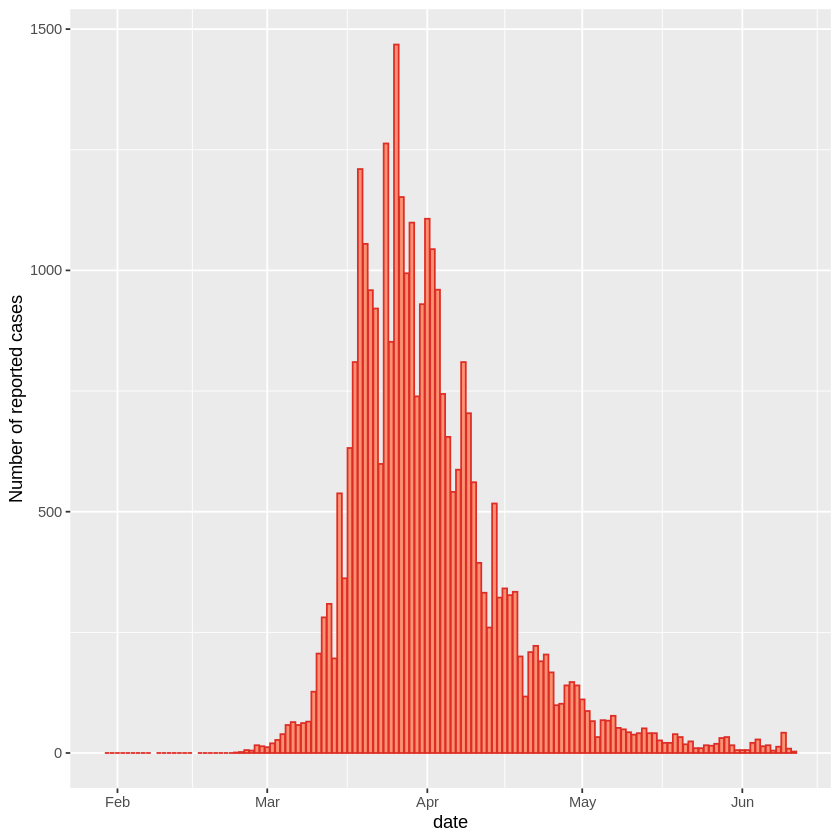

In [14]:
df_swiss %>% 
  ggplot() + 
  geom_bar(mapping = aes(x = date, y = report_dt), fill = c_mid, color = c_dark, stat = "identity") +
  labs(y="Number of reported cases")

### We are going to fit our basic model to the COVID-19 data, but we first need to make a few changes. In the influenza example, the number of students in bed was data on the disease prevalence, that is the number of students infected at time t. In this new setting, we only have access to the number of new cases on each given day, which constitutes incidence data. In a SIR model, the incidence of the disease at time t is the number of people leaving the Susceptible compartment at time t.

In [15]:
# Swiss population
N <- 8.57E6;

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

#### Fitting data from a serological survey
#### We are going to use data from the Lancet survey published in June 2020. For simplicity, we only fit the results from week 5 of the survey, neglect consideration of tests sensitivity and specificity21, and makes the (strong) assumption that the results from Geneva are representative of Switzerland as a whole. Tests from week 5 have taken place in Geneva from May the 4th to May the 7th, and researchers have found 83 people with Covid-19 antibody on 775 people tested.

#### Anti-body test sensitivity is time-dependent and becomes good (around 85%) at 2 weeks and gets better afterwards22. Recovery time for mild cases is about two weeks, for severe cases three to six weeks23. Given that the time to develop detectable antibodies and the recovery time are quite similar, we can identify people having detectable COVID-19 antibodies with people in the R compartment of our model. Given this assumption, the probability of being detected by the survey is the proportion of people in the **R compartment** during the survey.

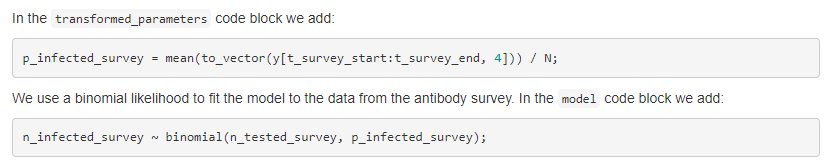

In [16]:
seir_model <- stan_model("./seir_ode_final.stan")

In [17]:
date_switch <- "2020-03-13" # date of introduction of control measures
tswitch <- df_swiss %>% 
            filter(date < date_switch) %>% 
            nrow() + 1 # convert time to number

In [18]:
tswitch

[1] 42

In [19]:
# Cases
cases <- df_swiss$report_dt

# times
n_days <- length(cases)
t <- seq(1, n_days, by = 1)
t0 = 0
ts <- t

In [20]:
data_seir <- list(n_days = n_days, tswitch = tswitch,t0 = t0, ts = ts, N = N, cases = cases)

In [21]:
date_survey_left <- "2020-05-04"
date_survey_right <- "2020-05-07"
t_survey_start <- df_swiss %>% filter(date < date_survey_left) %>% nrow() + 1 # convert time to number
t_survey_end <- df_swiss %>% filter(date < date_survey_right) %>% nrow() + 1 # convert time to number
n_infected_survey <-  83
n_tested_survey <-  775
# add these data to the data given to stan
data_seir_survey <- c(data_seir, list(t_survey_start = t_survey_start, 
                                                t_survey_end = t_survey_end,
                                                n_infected_survey = n_infected_survey,
                                                n_tested_survey = n_tested_survey))

In [22]:
fit_seir <- sampling(seir_model, 
                    data_seir, 
                    iter=1000,
                    seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.01667 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 166.7 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1334.33 seconds (Warm-up)
Chain 1:                1776.42 seconds (Sampling)
Chain 1:                3110.75 se

Warning message:
“There were 739 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [23]:
pars = c("beta", "gamma", "phi", "alpha","eta", 'nu', "xi", "p_rep")

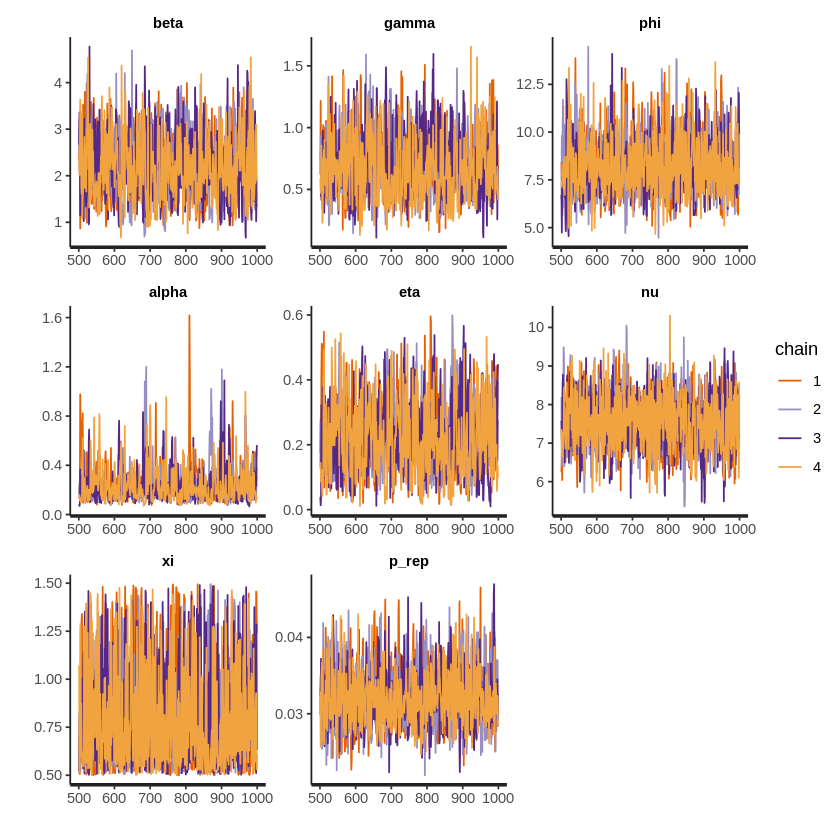

In [24]:
traceplot(fit_seir, pars=pars)

In [25]:
check_hmc_diagnostics(fit_seir)
summary(fit_seir, pars=pars)



Divergences:


0 of 2000 iterations ended with a divergence.




Tree depth:


739 of 2000 iterations saturated the maximum tree depth of 10 (36.95%).
Try increasing 'max_treedepth' to avoid saturation.




Energy:


E-BFMI indicated no pathological behavior.



,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,2.18798848,2.166955e-02,0.694325598,1.02327118,1.67772243,2.13608318,2.63542653,3.63229239,1026.6599,0.9991569
gamma,0.68158875,7.861544e-03,0.252908472,0.27448233,0.49198784,0.64954351,0.84020647,1.23009084,1034.9302,1.0014411
phi,8.28634422,3.519907e-02,1.496475978,5.74997506,7.21893767,8.14019486,9.16635414,11.55345480,1807.4950,1.0016705
alpha,0.23378845,5.778912e-03,0.142956342,0.09158813,0.14463207,0.19559830,0.27481649,0.60435337,611.9483,1.0001304
eta,0.22072358,4.489944e-03,0.111068968,0.04257764,0.13537208,0.20976709,0.29141546,0.46267751,611.9328,1.0012930
nu,7.57622868,1.728624e-02,0.711568165,6.17411390,7.08056363,7.58431938,8.06018052,9.02022325,1694.4630,1.0007470
xi,0.81104910,6.723043e-03,0.273454645,0.50686179,0.58277102,0.72293197,0.99421900,1.43491700,1654.3936,1.0013601
p_rep,0.03209428,9.281653e-05,0.003900935,0.02566544,0.02927776,0.03170127,0.03446095,0.04066456,1766.3908,0.9994738
